In [1]:
import os
from argparse import Namespace
from pathlib import Path
import librosa
from tqdm import tqdm
import noisereduce as nr

import numpy as np
# import modin.pandas as pd
import pandas as pd

import torch
import torchaudio
torchaudio.set_audio_backend("sox_io")

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# CONFIGURATIONS
IS_KAGGLE = False
if IS_KAGGLE:
    ROOT_DIR = Path('../../input/birdclef-2022')
else:
    ROOT_DIR = Path('../../datasets/birdclef-2022')
DATA_DIR = ROOT_DIR / "train_audio"

In [3]:
from math import ceil


def crop_or_pad(y, length, sr, train=True, offset=0, probs=None):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})
        probs {None or numpy array} -- Probabilities to use to chose where to crop (default: {None})
    Returns:
        1D np array -- Cropped array
    """
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if not train:
            start = 0 + offset
        elif probs is None:
            start = np.random.randint(len(y) - length)
        else:
            start = (
                    np.random.choice(np.arange(len(probs)), p=probs) + np.random.random()
            )
            start = int(sr * (start))

        y = y[start: start + length]

    return torch.from_numpy(y).float()


def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def compute_deltas(sg, width=9, order=1):
    def librosa_delta(data, order=1, width=9):
        return torch.from_numpy(librosa.feature.delta(data.numpy(), order=order, width=width))

    if sg.shape[1] < width:
        raise ValueError(
            f"""Delta not possible with current settings, inputs must be wider than
        {width} columns, try setting max_to_pad to a larger value to ensure a minimum width"""
        )
    new_channels = [
        torch.stack([c, librosa_delta(c, order=1), librosa_delta(c, order=2)]) for c in sg
    ]
    sg.data = torch.cat(new_channels, dim=0)
    return sg

audio2mfcc = torchaudio.transforms.MFCC(n_mfcc=64, melkwargs={'n_fft':2048, 'hop_length':256, 'n_mels':128})    

@torch.no_grad()
def create_mfcc(
        fname: str,
        reduce_noise: bool = False,
        frame_size: int = 5,
        sr: int = 16000,
        train: bool = True,
    ) -> list:
    waveform, sample_rate = torchaudio.load(fname)
    # print(f"Input: {waveform.size()}")

    # DownMixMono: convert to one channel. Some files have two channels
    waveform = waveform.contiguous().mean(-2).unsqueeze(-2).float()
    # print(f"DownMixMono: {waveform.size()}")

    # Convert to 16000Hz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sr)
    waveform = resample(waveform)
    # print(f"Resample: {waveform.size()}")

    waveform = crop_or_pad(
        waveform.squeeze().numpy(),
        length=frame_size * sr,
        sr=sr,
        train=train
    )
    waveform = waveform.unsqueeze(0)
    # print(f"ResizeSignal: {waveform.size()}")
    if reduce_noise:
        waveform = torch.tensor(nr.reduce_noise(
            y=waveform, sr=sample_rate, win_length=256, use_tqdm=False, n_jobs=2,
        ))

    # print(f"Before mfcc: {waveform.size()}")
    spectrograms = audio2mfcc(waveform)
    # print(f"MFCC: {spectrograms.size()}")
    mfcc = compute_deltas(spectrograms)
    # print(f"Delta: {spectrograms.size()}")
    mfcc = mfcc.float().div_(255.)
    return mfcc

@torch.no_grad()
def create_mfcc_inference(
        fname: str,
        reduce_noise: bool = False,
        frame_size: int = 5,
        sr: int = 16000
    ):
    waveform, sample_rate = torchaudio.load(fname)
    # print(f"Input: {waveform.size()}")

    # DownMixMono: convert to one channel. Some files have two channels
    waveform = waveform.contiguous().mean(-2).unsqueeze(-2).float()
    # print(f"DownMixMono: {waveform.size()}")

    # Convert to 16000Hz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sr)
    waveform = resample(waveform)
    # print(f"Resample: {waveform.size()}")
    
    nb = int(frame_size * sr)
    clip_mfccs = []
    for i in range(ceil(waveform.size()[-1] / nb)):
        cropped_waveform = crop_or_pad(
            waveform.squeeze().numpy(),
            length=frame_size * sr,
            sr=sr,
            train=False,
            offset=i*sr
        )
        cropped_waveform = cropped_waveform.unsqueeze(0)
        # print(f"ResizeSignal: {cropped_waveform.size()}")
        if reduce_noise:
            cropped_waveform = torch.tensor(nr.reduce_noise(
                y=cropped_waveform, sr=sample_rate, win_length=256, use_tqdm=False, n_jobs=2,
            ))
        # print(f"Before mfcc: {cropped_waveform.size()}")
        spectrograms = audio2mfcc(cropped_waveform)
        # print(f"MFCC: {spectrograms.size()}")
        mfcc = compute_deltas(spectrograms)
        # print(f"Delta: {spectrograms.size()}")
        # mfcc = mfcc.float().div_(255.)
        clip_mfccs.append(mfcc)
    return torch.stack((clip_mfccs))

In [4]:
# Debug
fname = Path("../../datasets/birdclef-2022/test_soundscapes/soundscape_453028782.ogg")
# fname = Path("../../datasets/birdclef-2022/train_audio/dunlin/XC588428.ogg")
spec = create_mfcc_inference(fname)
print(len(spec))
print(spec[0].size())

12
torch.Size([3, 64, 313])


# Model Training

In [5]:
from torch.utils.data import Dataset


class BirdCLEFDataset(Dataset):
    def __init__(self, root_dir='/kaggle/input/birdclef-2022', is_training=False, transform=None):
        self.root_dir = root_dir
        self.is_training = is_training
        if not is_training:
            self.data_dir = os.path.join(self.root_dir, 'test_soundscapes')
            self.label_file = os.path.join(self.root_dir, 'test.csv')
            
            # Preparing a sample submission file just to save the notebook and submit for the competition.
            # Note : When the notebook will be submitted the below cells will be working and the genuine output file will be produced.
            df = pd.read_csv(self.label_file)
            test = df.copy()
            test["target"] = [False for _ in range(len(test))]
            imp_features = ["row_id", "target"]
            test = test[imp_features]
            test.to_csv("submission.csv", index = False)
        else:
            self.data_dir = os.path.join(self.root_dir, 'train_audio')
            self.label_file = os.path.join(self.root_dir, 'train_metadata.csv')

        # Retrieve categories and its label name
        self.class_names = [
            "afrsil1","apapan","bkwpet","brnowl","cacgoo1","chemun","comwax",
            "fragul","grefri","hawgoo","iiwi","layalb","lotjae","merlin","norsho",
            "parjae","reccar","ribgul","saffin","sooshe","wantat1","whttro","akekee",
            "arcter","blkfra","brtcur","calqua","chukar","coopet","gadwal","gresca",
            "hawhaw","incter1","lcspet","madpet","mitpar","nutman","pecsan","redava",
            "rinduc","sander","sooter1","warwhe1","wiltur","akepa1","barpet","blknod",
            "bubsan","cangoo","cintea","crehon","gamqua","gryfra","hawpet1","jabwar",
            "leasan","magpet1","moudov","oahama","peflov","redjun","rinphe","semplo",
            "sopsku1","wesmea","yebcar","akiapo","bcnher","bongul","buffle","canvas",
            "comgal1","dunlin","glwgul","gwfgoo","hoomer","japqua","leater1","mallar3",
            "norcar","omao","perfal","redpha1","rocpig","sheowl","sora","wessan","yefcan",
            "akikik","belkin1","brant","bulpet","caster1","commyn","elepai","gnwtea",
            "hawama","houfin","kalphe","lessca","masboo","norhar2","osprey","pibgre",
            "refboo","rorpar","shtsan","spodov","wetshe","zebdov","amewig","bkbplo",
            "brnboo","burpar","categr","compea","ercfra","golphe","hawcoo","houspa",
            "kauama","lesyel","mauala","normoc","pagplo","pomjae","rempar","rudtur",
            "skylar","sposan","whfibi","aniani","bknsti","brnnod","buwtea","chbsan",
            "comsan","eurwig","grbher3","hawcre","hudgod","laugul","lobdow","maupar",
            "norpin","palila","puaioh","rettro","ruff","snogoo","towsol","whiter"
        ]
        self.num_classes = len(self.class_names)
        print('{:d} available classes'.format(self.num_classes))

        # Load image ids
        self.sound_files = []
        self.labels = []
        label_df = pd.read_csv(self.label_file)
        for index, row in label_df.iterrows():
            label_name = row["primary_label"]
            file_name = row["filename"]
            cat_id = self.class_names.index(label_name)
            self.sound_files.append(file_name)
            self.labels.append(cat_id)

        print('Dataset loaded with {:d} files'.format(len(self.sound_files)))

        # PyTorch Transform
        self.transform = transform


    def __len__(self):
        return len(self.sound_files)

    def __getitem__(self, index):
        """ Generate one sample of data
        """
        filename = self.sound_files[index]
        file_path = os.path.join(self.data_dir, filename)

        # To Tensor
        mfcc = create_mfcc(file_path)
        if self.transform:
            img = self.transform(img)

        label = self.labels[index]

        return mfcc, label

dataset = BirdCLEFDataset(root_dir=ROOT_DIR, is_training=True)

152 available classes
Dataset loaded with 14852 files


In [6]:
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler

class BirdCLEFDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, validation_split=0.2, num_workers=4, collate_fn=default_collate):
        self.validation_split = validation_split
        self.shuffle = shuffle

        self.batch_idx = 0
        self.n_samples = len(dataset)

        self.sampler, self.valid_sampler = self._split_sampler(self.validation_split)

        self.init_kwargs = {
            'dataset': dataset,
            'batch_size': batch_size,
            'shuffle': self.shuffle,
            'collate_fn': collate_fn,
            'num_workers': num_workers
        }
        super().__init__(sampler=self.sampler, **self.init_kwargs)

    def _split_sampler(self, split):
        if split == 0.0:
            return None, None

        idx_full = np.arange(self.n_samples)

        np.random.seed(0)
        np.random.shuffle(idx_full)

        if isinstance(split, int):
            assert split > 0
            assert split < self.n_samples, "validation set size is configured to be larger than entire dataset."
            len_valid = split
        else:
            len_valid = int(self.n_samples * split)

        valid_idx = idx_full[0:len_valid]
        train_idx = np.delete(idx_full, np.arange(0, len_valid))

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # turn off shuffle option which is mutually exclusive with sampler
        self.shuffle = False
        self.n_samples = len(train_idx)

        return train_sampler, valid_sampler

    def split_validation(self):
        if self.valid_sampler is None:
            return None
        else:
            return torch.utils.data.DataLoader(sampler=self.valid_sampler, **self.init_kwargs)

data_loader = BirdCLEFDataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)
val_data_loader = data_loader.split_validation()
print(len(data_loader))

372


In [7]:
class_names = [
    "afrsil1","apapan","bkwpet","brnowl","cacgoo1","chemun","comwax",
    "fragul","grefri","hawgoo","iiwi","layalb","lotjae","merlin","norsho",
    "parjae","reccar","ribgul","saffin","sooshe","wantat1","whttro","akekee",
    "arcter","blkfra","brtcur","calqua","chukar","coopet","gadwal","gresca",
    "hawhaw","incter1","lcspet","madpet","mitpar","nutman","pecsan","redava",
    "rinduc","sander","sooter1","warwhe1","wiltur","akepa1","barpet","blknod",
    "bubsan","cangoo","cintea","crehon","gamqua","gryfra","hawpet1","jabwar",
    "leasan","magpet1","moudov","oahama","peflov","redjun","rinphe","semplo",
    "sopsku1","wesmea","yebcar","akiapo","bcnher","bongul","buffle","canvas",
    "comgal1","dunlin","glwgul","gwfgoo","hoomer","japqua","leater1","mallar3",
    "norcar","omao","perfal","redpha1","rocpig","sheowl","sora","wessan","yefcan",
    "akikik","belkin1","brant","bulpet","caster1","commyn","elepai","gnwtea",
    "hawama","houfin","kalphe","lessca","masboo","norhar2","osprey","pibgre",
    "refboo","rorpar","shtsan","spodov","wetshe","zebdov","amewig","bkbplo",
    "brnboo","burpar","categr","compea","ercfra","golphe","hawcoo","houspa",
    "kauama","lesyel","mauala","normoc","pagplo","pomjae","rempar","rudtur",
    "skylar","sposan","whfibi","aniani","bknsti","brnnod","buwtea","chbsan",
    "comsan","eurwig","grbher3","hawcre","hudgod","laugul","lobdow","maupar",
    "norpin","palila","puaioh","rettro","ruff","snogoo","towsol","whiter"
]

device = "cuda:0" if torch.cuda.is_available() else 'cpu'

hparams = {
    "lr": 3e-3,
    "epochs": 20,
    "batch_size": 32,
    "data_len": len(data_loader)
}

In [8]:
import torch.nn as nn
import pytorch_lightning as pl
from torch.nn import functional as F
import torchmetrics

class BirdCLEFModel(pl.LightningModule):
    def __init__(self, backbone, input_shape, num_classes, loss_fn, learning_rate=2e-4):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.num_classes = num_classes

        # Loss function
        self.loss_fn = loss_fn

        self.accuracy = torchmetrics.Accuracy()

        self.backbone = backbone
        n_sizes = backbone.fc.in_features
        self.backbone.fc = nn.Sequential()
        # # layers are frozen by using eval()
        # self.backbone.eval()
        # # freeze params
        # for param in self.backbone.parameters():
        #     param.requires_grad = False
        self.backbone.fc = nn.Linear(n_sizes, num_classes)
        
        # n_sizes = self._get_conv_output(input_shape)
        # self.classifier = nn.Linear(n_sizes, num_classes)

    # returns the size of the output tensor going into the Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = self.backbone(x)
        return x
    
    # will be used during inference
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        # x = F.log_softmax(self.classifier(x), dim=1)
        # x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        # loss = F.cross_entropy(y_hat, y)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_epoch=True)
        self.accuracy(y_hat, y)
        self.log('train_acc_step', self.accuracy.compute())
        return loss
    
    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        # loss = F.cross_entropy(y_hat, y)
        loss = self.loss_fn(y_hat, y)
        self.log('valid_loss', loss, on_step=True)
        self.accuracy(y_hat, y)
        self.log('val_acc_step', self.accuracy.compute())
    
    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute())

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        # loss = F.cross_entropy(y_hat, y)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss)
        self.accuracy(y_hat, y)
        self.log('test_acc_step', self.accuracy.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.9)

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.learning_rate,
            steps_per_epoch=hparams["data_len"],
            epochs=hparams["epochs"]
        )
        scheduler = {"scheduler": scheduler, "interval" : "step" }
        return [optimizer], [scheduler]

In [9]:
# # Cell
# class LabelSmoothingCrossEntropy(torch.nn.Module):
#     y_int = True
#     def __init__(self, eps:float=0.1, weight=None, reduction='mean'):
#         self.eps = eps
#         self.weight = weight
#         self.reduction = reduction

#     def forward(self, output, target):
#         c = output.size()[1]
#         log_preds = F.log_softmax(output, dim=1)
#         if self.reduction=='sum': loss = -log_preds.sum()
#         else:
#             loss = -log_preds.sum(dim=1) #We divide by that size at the return line so sum and not mean
#             if self.reduction=='mean':  loss = loss.mean()
#         return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), weight=self.weight, reduction=self.reduction)

#     # def activation(self, out): return F.softmax(out, dim=-1)
#     # def decodes(self, out):    return out.argmax(dim=-1)

def label_smoothing_cross_entropy_loss(output, target, eps=0.1, weight=None, reduction='mean'):
        c = output.size()[1]
        log_preds = F.log_softmax(output, dim=1)
        if reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1) #We divide by that size at the return line so sum and not mean
            if reduction=='mean':  loss = loss.mean()
        return loss*eps/c + (1-eps) * F.nll_loss(log_preds, target.long(), weight=weight, reduction=reduction)

# from fastai.losses import LabelSmoothingCrossEntropy
# loss_function = torch.nn.CrossEntropyLoss()
# loss_function = loss_function.to(device)
loss_function = label_smoothing_cross_entropy_loss


In [10]:
import torchvision.models as models

backbone = models.resnet34(pretrained=True)
model = BirdCLEFModel(
    backbone=backbone,
    input_shape=(3, 64, 313),
    num_classes=len(class_names),
    loss_fn=loss_function,
    learning_rate=hparams["lr"]
)

model = model.to(device)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Finding best initial lr: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Suggested LR: 0.002754228703338169


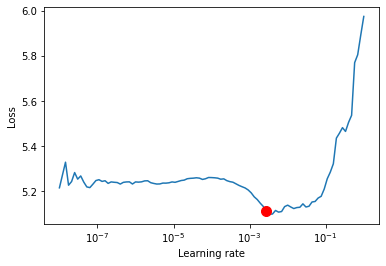

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Init ModelCheckpoint callback, monitoring 'val_loss'
callbacks = [
    ModelCheckpoint(monitor="val_acc_epoch"),
    EarlyStopping(monitor="valid_loss", patience=5, verbose=False)
]
  
trainer = pl.trainer.Trainer(
    max_epochs=hparams["epochs"],
    gpus=1,
    callbacks=callbacks,
    accelerator="gpu",
    auto_lr_find=True
)
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model, train_dataloaders=data_loader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"Suggested LR: {new_lr}")

# update hparams of the model
model.learning_rate = new_lr

In [12]:
trainer.fit(model, data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type     | Params
--------------------------------------
0 | accuracy | Accuracy | 0     
1 | backbone | ResNet   | 21.4 M
--------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.451    Total estimated model params size (MB)


Epoch 8:  31%|███       | 144/465 [01:19<02:56,  1.81it/s, loss=2.12, v_num=21]

In [ ]:
trainer.test(model, test_dataloaders=val_data_loader)